In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from py12box_invert.invert import Invert
from py12box_laube import get_data
from py12box_agage.utils import get_inversion_params

... CFC-13
Setting up inversion for CFC-13

No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
[0.0017187500000000002, 0.0015625]
[1.1000000000000002e-12, 1e-12]
[1.1000000000000002e-12, 1e-12]
[0.0015126154998422103, 0.0015625]
[1e-12, 1e-12]
[1e-12, 1e-12]
[0.0015618302528720349, 0.0015625]
[1e-12, 1e-12]
[1e-12, 1e-12]
... completed in 2 iterations
... stratospheric lifetime: 640.1
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 640.1
... done in 0.0028 s
Calculating flux sensitivity on 1 threads...
... done
Spinning up for 9 years and estimating initial conditions...
... done
Run inversion...
... done
Calculating outputs...
... calculating posterior ensembles
... done



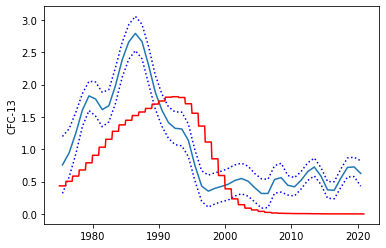

In [4]:
# Run for "CFC-112", "CFC-112a", "CFC-113","CFC-113a", "CFC-114", "CFC-114a"

# Uncertainty for 112a, 112 and 113a from Laube 2014
# Uncertainty for 114a say 20% as Davis et al uncertainty is tiny
# Others come from file (SPARC report)
lifetime_uncertainty_dict = {"CFC-112a":0.55,"CFC-112":0.35, "CFC-113a":0.8,
                            "CFC-113":0.2, "CFC-114":0.2, "CFC-114a":0.2, 
                            "CFC-115":0.2, "CFC-13":0.2}   

species_list = ["CFC-13"]
network = "agage" # agage or laube
# species_list = ["CFC-112", "CFC-112a", "CFC-113","CFC-113a", "CFC-114", "CFC-114a"]
for species in species_list:
    
    scale_error = 0.03
    if species == "CFC-114":
        uncertainty_scale = 0.05
    else:
        uncertainty_scale = 0.2
    lifetime_uncertainty = lifetime_uncertainty_dict[species]

    print(f"... {species}")

    # Work out paths
    project_path = get_data(f"{species}")
    if network == "agage":
        parts = list(project_path.parts)
        parts[-2] = parts[-2] + "_agage"
        project_path = Path(*parts)
    obs_path = project_path / f"inputs/{species}_obs_{network}.csv"
    output_path = project_path / f"outputs/{species}_out.p"

    nthreads = 1

    if not output_path.parent.exists():
        output_path.parent.mkdir()

    inversion_params = get_inversion_params(species)
    
    # Set up inversion
    inv = Invert(project_path / "inputs", species,
                obs_path = obs_path,
                method="rigby14",#"iterative_rigby14", #"analytical_gaussian",#
                n_threads=nthreads,
                sensitivity_freq=inversion_params.loc["Sensitivity frequency"],
                end_year=2021.)

    # Calculate emissions uncertainty
    emissions_box = inv.mod.emissions.mean(axis=0)

    invert_uncertainty = inv.mod.emissions.sum(axis=1).max() * inversion_params.loc["Growth uncertainty (%)"]/100.
    invert_uncertainty_box = np.sqrt(invert_uncertainty**2 * emissions_box / emissions_box.sum())
    invert_uncertainty_min = invert_uncertainty*0.01

    invert_uncertainty_box[invert_uncertainty_box < invert_uncertainty_min] = invert_uncertainty_min.copy()

    # Run inversion
    inv.run_inversion(invert_uncertainty_box,
                lifetime_error=inversion_params.loc["Overall lifetime uncertainty (%)"]/100.,
                scale_error=np.mean([inversion_params.loc["Scale error plus (%)"]/100.,
                    inversion_params.loc["Scale error minus (%)"]/100.]))

    # Save outputs
    # inv.save(output_path)

    # Write to csv
    # inv.to_csv(project_path / "outputs/")
    
    plt.figure()
    plt.plot(inv.outputs.emissions_global_annual[0],inv.outputs.emissions_global_annual[1])
    plt.plot(inv.outputs.emissions_global_annual[0],inv.outputs.emissions_global_annual[1]+
    inv.outputs.emissions_global_annual[2], "b:")
    plt.plot(inv.outputs.emissions_global_annual[0],inv.outputs.emissions_global_annual[1]-
    inv.outputs.emissions_global_annual[2], "b:")
    #plt.xlim(2010,2021)
    #plt.ylim(-10,10)
    plt.plot(inv.mod_prior.time, inv.mod_prior.emissions.sum(1), "r")
    plt.ylabel(species)

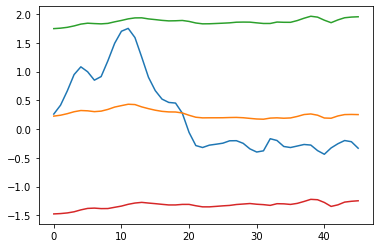

In [6]:
plt.plot(inv.outputs.emissions_annual[1])

(14.5, 15.5)

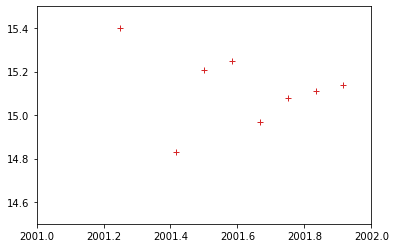

In [41]:
plt.plot(inv.obs.time,inv.obs.mf,"+")
plt.xlim((2001,2002))
plt.ylim((14.5,15.5))

Run inversion...
... done
Calculating outputs...
... calculating posterior ensembles
... done



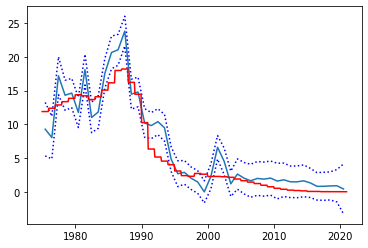

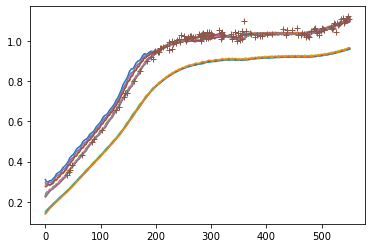

In [253]:
plt.plot(inv.mod.mf)
plt.plot(inv.obs.mf, "+")

0.23

PosixPath('/user/home/lw13938/work/py12box/py12box/data/inputs')

[58.7617325   6.45776341  3.03980863  2.25208676]
59.186800000000005
[54.03093884 17.9116784  12.28905081 10.57761551]
0.5918680000000001
[54.03093884 17.9116784  12.28905081 10.57761551]
